1. <B>Reading</B>

In [41]:

import os
import re
import time

import tensorflow as tf
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import unicodedata
import numpy as np


In [42]:
parsed_path="/home/alex/dev/AiLearning/DataSetStore/chat_bot/ParsedOtvety.txt"

def get_num_lines(file_path):
    fp=open(file_path,"r+")
    buf = mmap.mmap(fp.fileno(),0)
    lines=0
    while buf.readline():
        lines = lines+1
    return lines

def parse_qa(input_path: str,
             limit: int,
             verbose=False) -> list:

    result_list=list()
    with open(input_path,"r") as reader:
        answer_list=list()
        question=None
        for line in tqdm(reader):
            if verbose:
                print (line)
                time.sleep(1)
            if line.find("===")>=0:
                question = line.split("===")[1]
                answer = line.split("===")[0]
                result_list.append([question,answer])
                if len(result_list)>limit:
                    break
    return [qa for qa in result_list if len(qa[0])>2 and len(qa[1])>2]



Testing

In [43]:
print ("Test case -1:",parse_qa(input_path=parsed_path,limit=10,verbose=False))

0it [00:00, ?it/s]

Test case -1: [['меня вобще прикалывает эта тема :). \n', 'Как парни относятся к цветным линзам? Если у девушки то зеленые глаза, то голубые...)) .'], ['Если это "счастье " действительно на вас свалилось, лучше пойти в милицию и заявить о находке. Такие деньги просто так не терют, а что самое интересное их неприменно будут искать и поверьте мне найдут, видел подобное в жизни. Можно нарваться на бабушку конечно, которая хотела помоч внуку с покупкой квартиры, а можно на бандитов, которые будут с вами разговаривать иначе чем бабушка с милицией. Выбор за вами, есть еще конечно шанс, что это подарок с выше за котрый с вас никто не спросит, тогда лучше отдать хотябы 500 на благотворительность. дабы не спугнуть удачу!. \n', 'Что делать, сегодня нашёл 2 миллиона рублей? .'], ['ЭБУ — электронный блок управления двигателем автомобиля, его другое название — контроллер. Он принимает информацию от многочисленных датчиков, обрабатывает ее по особым алгоритмам и, отталкиваясь от полученных данных, о

2. <b>Prepocessing</b>

In [44]:
def preprocess_sentence(w: str) -> str:
  w = w.lower().strip()

  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
  w = re.sub(r"([?.!,])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  w = re.sub(r"[^a-zA-Zа-яА-Я?.!,']+", " ", w)

  w = w.strip()

  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  w = '<start> ' + w + ' <end>'
  return w

def apply_preprocess(line_2d_list: list, verbose = False) -> tuple:
    line_2d_list = [[preprocess_sentence(line) for line in line_list]  for line_list in line_2d_list]
    if verbose:
        print (line_2d_list)
    return zip(*line_2d_list)

def make_preprocessing(file_path: str, line_limit=None, verbose=False):
    return apply_preprocess(
        line_2d_list=parse_qa(input_path=file_path,limit=line_limit,verbose=verbose),
        verbose=verbose)

<b>Testing</b>


In [45]:
print ("Test make-preprocessing:", make_preprocessing(file_path=parsed_path, line_limit=10, verbose=True))

0it [00:00, ?it/s]

===вопрос о ТДВ)) давно и хорошо отдыхаем)) ЛИЧНО ВАМ здесь кого советовали завести?)) . 

Как парни относятся к цветным линзам? Если у девушки то зеленые глаза, то голубые...)) .===меня вобще прикалывает эта тема :). 

Что делать, сегодня нашёл 2 миллиона рублей? .===Если это "счастье " действительно на вас свалилось, лучше пойти в милицию и заявить о находке. Такие деньги просто так не терют, а что самое интересное их неприменно будут искать и поверьте мне найдут, видел подобное в жизни. Можно нарваться на бабушку конечно, которая хотела помоч внуку с покупкой квартиры, а можно на бандитов, которые будут с вами разговаривать иначе чем бабушка с милицией. Выбор за вами, есть еще конечно шанс, что это подарок с выше за котрый с вас никто не спросит, тогда лучше отдать хотябы 500 на благотворительность. дабы не спугнуть удачу!. 

Эбу в двенашке называется Итэлма что за эбу? .===ЭБУ — электронный блок управления двигателем автомобиля, его другое название — контроллер. Он принимает информ

3. <b>Tokenizer</b>

In [46]:
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer

# num_words    the maximum number of words to keep, based on word frequency. Only the most common num_words-1 words will be kept.
# filters	   a string where each element is a character that will be filtered from the texts. The default is all punctuation, plus tabs and line breaks, minus the ' character.
# lower	       boolean. Whether to convert the texts to lowercase.
# split	str.   Separator for word splitting.
# char_level   if True, every character will be treated as a token.
# oov_token	   if given, it will be added to word_index and used to replace out-of-vocabulary words during text_to_sequence calls
# analyzer	   function. Custom analyzer to split the text. The default analyzer is text_to_word_sequence

# tf.keras.preprocessing.text.Tokenizer(
#     num_words=None,
#     filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
#     lower=True,
#     split=' ',
#     char_level=False,
#     oov_token=None,
#     analyzer=None,
#     **kwargs
# )

def tokenize(text_list: list) -> tuple:
  # overriding default filters and building internal courpus
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
  lang_tokenizer.fit_on_texts(text_list)
    
  # building numerical sequence. Each word is coded as the respective corpus number
  tensor = lang_tokenizer.texts_to_sequences(text_list)

  # messages have different lenght. Padding allows to make tensors with same length
  # length difference is compensated by adding ZEROES before or after
  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,padding='post')

  return tensor, lang_tokenizer


def load_dataset(file_path: str, line_limit=None):

  targ_lang, inp_lang = make_preprocessing(file_path=file_path,
                                           line_limit=line_limit)

  input_tensor, inp_lang_tokenizer = tokenize(text_list=inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(text_list=targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [47]:
LIMIT = 20
# Making tensors
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(file_path=parsed_path,line_limit=LIMIT)

# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(
    input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))


# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]
print (max_length_targ,max_length_inp)

0it [00:00, ?it/s]

16 16 4 4
325 60


In [48]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 10

steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024

vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [49]:
example_input_batch, example_target_batch = next(iter(dataset))

print (example_input_batch.shape, example_target_batch.shape)

(10, 60) (10, 325)


4. <b>Making Encoder/Decoder NN</b>

In [50]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [51]:
# Encoder:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)

print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (10, 60, 1024)
Encoder Hidden state shape: (batch size, units) (10, 1024)


In [52]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [53]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [54]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (10, 712)


In [55]:
# Define the optimizer and the loss function
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [56]:
# Checkpoints (Object-based saving)

checkpoint_dir = './training_attention_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [57]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [70]:
EPOCHS = 300

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    #print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
    #                                             batch,
    #                                             batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Loss 1.2173
Time taken for 1 epoch 5.4570701122283936 sec

Epoch 2 Loss 1.0384
Time taken for 1 epoch 6.537998199462891 sec

Epoch 3 Loss 1.0111
Time taken for 1 epoch 5.475861549377441 sec

Epoch 4 Loss 0.9977
Time taken for 1 epoch 6.4097230434417725 sec

Epoch 5 Loss 1.0444
Time taken for 1 epoch 5.481405735015869 sec

Epoch 6 Loss 0.9608
Time taken for 1 epoch 6.579037666320801 sec

Epoch 7 Loss 0.5163
Time taken for 1 epoch 5.565431833267212 sec

Epoch 8 Loss 0.8663
Time taken for 1 epoch 7.166451454162598 sec

Epoch 9 Loss 0.8774
Time taken for 1 epoch 5.538378953933716 sec

Epoch 10 Loss 0.5749
Time taken for 1 epoch 6.66727614402771 sec

Epoch 11 Loss 0.8698
Time taken for 1 epoch 5.580607175827026 sec

Epoch 12 Loss 0.8986
Time taken for 1 epoch 6.6436755657196045 sec

Epoch 13 Loss 0.8543
Time taken for 1 epoch 5.575662851333618 sec

Epoch 14 Loss 0.4095
Time taken for 1 epoch 6.672415256500244 sec

Epoch 15 Loss 0.6417
Time taken for 1 epoch 5.578219890594482 sec

Ep

In [71]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))
  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)
  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)
  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()
    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [72]:
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [73]:
inp_lang.word_index

{'.': 1,
 '?': 2,
 '<start>': 3,
 '<end>': 4,
 'как': 5,
 ',': 6,
 'в': 7,
 'и': 8,
 'на': 9,
 'что': 10,
 'если': 11,
 'или': 12,
 'при': 13,
 'не': 14,
 'ли': 15,
 'для': 16,
 'к': 17,
 'у': 18,
 'то': 19,
 'эбу': 20,
 'за': 21,
 'академия': 22,
 'вампиров': 23,
 'сколько': 24,
 'вас': 25,
 'с': 26,
 'какие': 27,
 'пожалуйста': 28,
 'из': 29,
 'вам': 30,
 'почему': 31,
 'чем': 32,
 'помогите': 33,
 'ipad': 34,
 'приказ': 35,
 'вместе': 36,
 'медное': 37,
 'литье': 38,
 'урок': 39,
 'парни': 40,
 'относятся': 41,
 'цветным': 42,
 'линзам': 43,
 'девушки': 44,
 'зеленые': 45,
 'глаза': 46,
 'голубые': 47,
 'делать': 48,
 'сегодня': 49,
 'наш': 50,
 'л': 51,
 'миллиона': 52,
 'рублей': 53,
 'двенашке': 54,
 'называется': 55,
 'итэлма': 56,
 'даный': 57,
 'момент': 58,
 'частей': 59,
 'книги': 60,
 'защититься': 61,
 'от': 62,
 'энергетического': 63,
 'вампира': 64,
 'кто': 65,
 'выращивает': 66,
 'магнолию': 67,
 'открытом': 68,
 'грунте': 69,
 'средней': 70,
 'полосе': 71,
 'россии': 7

Input: <start> момент миллиона защититься девушки <end>
Predicted translation: это подарок с приказами о командировках хранятся вместе с милицией . <end> 


/tmp/ipykernel_67847/2287643495.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_67847/2287643495.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


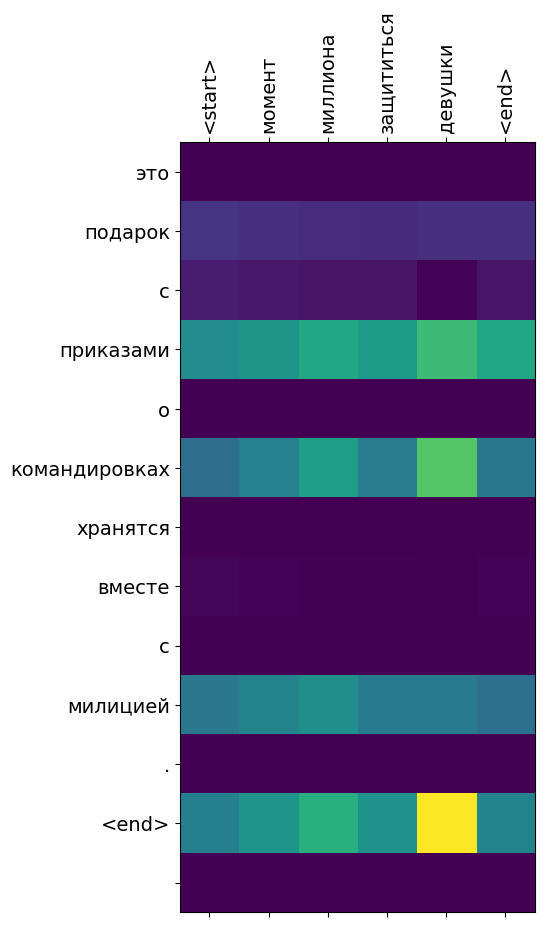

In [74]:
translate('момент миллиона защититься девушки')

Input: <start> волос выращивает <end>
Predicted translation: это подарок с покупкой квартиры , которая хотела помоч внуку с милицией . <end> 


/tmp/ipykernel_67847/2287643495.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_67847/2287643495.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


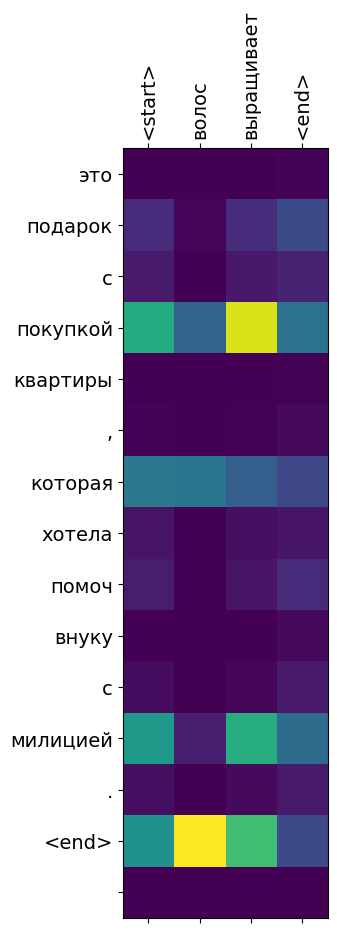

In [79]:
translate('волос выращивает')

Input: <start> регион <end>
Predicted translation: p мин ди кит . br при встрече или при общении с неприятным человеком мысленно представить себя за вами , который почувствовал опасность , что между вами зеркальная стена , мысленно покрывает свое биополе иглами и указательным пальцами другой руки , который почувствовал опасность , что между вами зеркальная стена , мысленно покрывает свое биополе иглами и указательным пальцами другой руки , который почувствовал опасность , что между вами зеркальная стена , мысленно покрывает свое биополе иглами и указательным пальцами другой руки , который почувствовал опасность , что между вами зеркальная стена , мысленно покрывает свое биополе иглами и указательным пальцами другой руки , который почувствовал опасность , что между вами зеркальная стена , мысленно покрывает свое биополе иглами и указательным пальцами другой руки , который почувствовал опасность , что между вами зеркальная стена , мысленно покрывает свое биополе иглами и указательным пал

/tmp/ipykernel_67847/2287643495.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_67847/2287643495.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


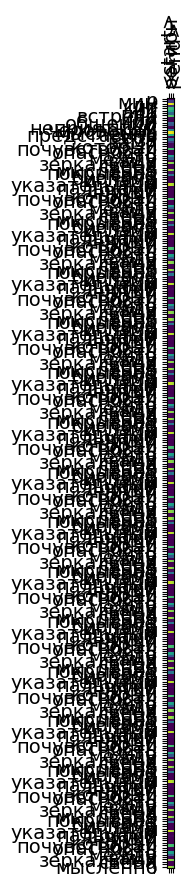

In [80]:
translate('регион')